# Determining an Effective Math Teaching Method for a Junior High School

    Author: Roelle Kim
    Date: 2022-03-27

# Problem Definition
    A Junior High School in your School District is looking for an efficient way to teach math courses for their 8th graders. The school has three math teachers - Ms. Wessen, Ms. Smith and Ms. Ruger. Ms. Wessen believes students learn from the traditional method better while the other two teachers believe they do from the standard-based method.
    
    So far, all 3 teachers have been delivering classes using the teaching approaches they prefer. However, at the recent school board meeting, the school suggested they want to apply the same teaching method and the same textbook for all students. They expect to see the selected method generally improve students' math scores.
    
    Using student performance data that contains each student's gender, ethnicity, socio-economic status, math scores and the assigned math teacher, various models will be built to find out if one teaching method is superior to the other.

# Exploratory Data Analysis (EDA)

## Load Packages and Data

Before we get further into EDA, we need to import required packages and data.

In [1]:
pip install pyreadstat # To read sav file

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import makedirs
from os import path
from keras.models import load_model

from sklearn import metrics
from sklearn.model_selection import train_test_split
import statsmodels.api       as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from   sklearn.metrics         import mean_squared_error

from tensorflow.keras.optimizers import Adamax
from keras.models import Sequential
from keras.layers                import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection     import GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

from sklearn.ensemble     import BaggingRegressor

In [3]:
# import data
PATH = '../input/students-math-score-for-different-teaching-style/'
FILE = "1ResearchProjectData.sav"
df = pd.read_spss('../input/students-math-score-for-different-teaching-style/1ResearchProjectData.sav')
df.head(10)

,Student,Teacher,Gender,Ethnic,Freeredu,Score,wesson
0,1.0,Ruger,Female,Asian,Free lunch,76.0,Ruger_Smith
1,2.0,Ruger,Female,Hispanic,Paid lunch,56.0,Ruger_Smith
2,3.0,Ruger,Female,African-American,Free lunch,34.0,Ruger_Smith
3,4.0,Ruger,Female,Asian,Paid lunch,59.0,Ruger_Smith
4,5.0,Ruger,Male,Hispanic,Free lunch,73.0,Ruger_Smith
5,6.0,Ruger,Male,Caucasian,Paid lunch,58.0,Ruger_Smith
6,7.0,Ruger,Female,African-American,Paid lunch,62.0,Ruger_Smith
7,8.0,Ruger,Male,Hispanic,Free lunch,40.0,Ruger_Smith
8,9.0,Ruger,Female,African-American,Free lunch,82.0,Ruger_Smith
9,10.0,Ruger,Male,African-American,Paid lunch,78.0,Ruger_Smith


## Data Dictionary

Data dictionary shows the nice overview of our dataset.

In [4]:
# lists to create a new dataframe
column_n_li = df.columns.values
sample_data_li = df.iloc[0].values

# count unique values per column
unique_counts_li = []
for col_n in column_n_li:
    unique_counts_li.append(len(df[col_n].unique()))

# count null values per column
null_counts = df.isna().sum()
null_counts_li = null_counts.values

# for numeric only
dfNum = df.describe()
average_li = dfNum.mean(axis=0).rename('Average')
sd_li = dfNum.std(axis=0).rename('SD')
min_li = dfNum.min(axis=0).rename('Min')
max_li = dfNum.max(axis=0).rename('Max')
numeric_dfs = [average_li, sd_li, min_li, max_li]

numeric_df_joined = pd.concat(numeric_dfs, join='inner', axis=1)

data_dict = {
    "Sample Data" : sample_data_li
    , "Unique Counts" : unique_counts_li
    , "Null Counts" : null_counts_li
}

data_dict_df = pd.DataFrame(data_dict, index=column_n_li)
data_dict_df = pd.concat([data_dict_df, numeric_df_joined], join='outer', axis=1)

# replace nan with an empty string
data_dict_df.fillna('', inplace=True)

data_dict_df

,Sample Data,Unique Counts,Null Counts,Average,SD,Min,Max
Student,1.0,217,1,116.18725,77.542899,1.0,216.0
Teacher,Ruger,4,1,,,,
Gender,Female,3,1,,,,
Ethnic,Asian,5,1,,,,
Freeredu,Free lunch,3,1,,,,
Score,76.0,64,1,77.454325,61.401374,16.361453,216.0
wesson,Ruger_Smith,2,0,,,,


Student column is replaced with incremental numbers to protect students' privacy. Other columns are showing each student's ethnicity, socioeconomic status (free lunch or paid lunch), gender, math score and whom they have for their math classes.

"wesson" column shows what style of math education each student is receiving. "Ruger_Smith" is the standards-based method, conducted by Ms. Ruger and Ms. Smith. "Wesson" is the traditional method, conducted by Ms. Wesson.

All rows except for the "wesson" have 1 null counts.

## Null Row

In [5]:
df[df.isna().any(axis=1)]

,Student,Teacher,Gender,Ethnic,Freeredu,Score,wesson
216,NaN,NaN,NaN,NaN,NaN,NaN,Ruger_Smith


It appeared almost all columns have 1 null count because there was an entry that has everything missing except for the "wesson" value. Although we have to avoid dropping anything from the original dataset, we will be removing this row as it is almost certain that this row will not be able to contribute much to training of the model.

In [6]:
# drop the null row.
df.dropna(inplace = True)

print("\n***** After dropping a null row")
df.info()


***** After dropping a null row
<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Student   216 non-null    float64 
 1   Teacher   216 non-null    category
 2   Gender    216 non-null    category
 3   Ethnic    216 non-null    category
 4   Freeredu  216 non-null    category
 5   Score     216 non-null    float64 
 6   wesson    216 non-null    category
dtypes: category(5), float64(2)
memory usage: 6.8 KB


Now all entries are non-null.

## Feature Segmentation
Students will be categorized in 4 groups based on their grades (A being the highest and D being the lowest).

In [7]:
# define the number of partitions
NUM_OF_GROUPS = 4

In [8]:
# sort dataframe
sortedDf = df.sort_values(by="Score", ascending=False, ignore_index=True)

def assignGroup(df, numGroup):
    """
    Create a "Group" column to the passed dataframe and assign an alphabet based on the index.
    :param df: sorted dataframe
    :param numGroup: number of groups desired to create
    :return: None
    """
    numRow, numCol = df.shape[0], df.shape[1]
    groupRowSize = int(np.floor(numRow / numGroup))

    for i in range(numGroup):
        for j in range(groupRowSize):
            df.loc[i*groupRowSize + j, "Group"] = chr(65 + i)

assignGroup(sortedDf, NUM_OF_GROUPS)

In [9]:
sortedDf

,Student,Teacher,Gender,Ethnic,Freeredu,Score,wesson,Group
0,100.0,Smith,Male,Asian,Paid lunch,95.0,Ruger_Smith,A
1,119.0,Smith,Male,African-American,Free lunch,95.0,Ruger_Smith,A
2,133.0,Smith,Female,Caucasian,Paid lunch,95.0,Ruger_Smith,A
3,213.0,Wesson,Male,Hispanic,Free lunch,94.0,Wesson,A
4,151.0,Wesson,Male,African-American,Free lunch,93.0,Wesson,A
...,...,...,...,...,...,...,...,...
211,44.0,Ruger,Male,African-American,Free lunch,32.0,Ruger_Smith,D
212,29.0,Ruger,Male,Hispanic,Paid lunch,32.0,Ruger_Smith,D
213,54.0,Ruger,Female,Asian,Free lunch,30.0,Ruger_Smith,D
214,48.0,Ruger,Female,Asian,Free lunch,30.0,Ruger_Smith,D


<AxesSubplot:xlabel='Group', ylabel='Score'>

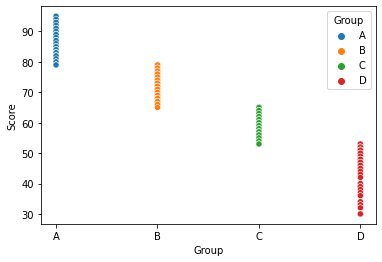

In [10]:
sns.scatterplot(x="Group", y="Score", data=sortedDf, ci =None, hue="Group")

In [11]:
def GroupMinMax(groupNLi: list, df: pd.DataFrame, groupColN: str, minmaxColN: str):
    """
    Create a dataframe that shows the min and max scores of each group.
    :param groupNLi: list of group names
    :param df: dataframe
    :param groupColN: name of the group column
    :param minmaxColN: name of the score column
    :return: a new dataframe
    """
    resDf = pd.DataFrame()
    for n in groupNLi:
        groupItem = {
             "min" : df[df[groupColN] == n][minmaxColN].min()
            , "max" : df[df[groupColN] == n][minmaxColN].max()
            , "average" : df[df[groupColN] == n][minmaxColN].mean()
            , "sd" : df[df[groupColN] == n][minmaxColN].std()
        }
        groupDf = pd.DataFrame(groupItem, index=[n])
        resDf = pd.concat([resDf, groupDf])
    return resDf

GroupMinMax(["A", "B", "C", "D"], sortedDf, "Group", "Score")

,min,max,average,sd
A,79.0,95.0,86.203704,4.691943
B,65.0,79.0,71.462963,3.849592
C,53.0,65.0,59.425926,3.663187
D,30.0,53.0,44.000000,7.374101


- Group A is composed of studenets with the highest grades (>= 79 and <= 95)
- Group B is compossed of students with the second highest grades (>= 65 and <= 79)
- Group C is composed of students with the second lowest grades (>= 53 and <= 65)
- Group D is composed of students with the failing grades (>= 30 and <= 53)

To clarify what method is being used to teach each student, a new column called "method" will be created. If the student is having Ms. Ruger or Ms. Smith for their math class, they are receiving a "standard" style of education. If the studetn is having Ms. Wesson for their math class, they are receiving a "Traditional" style of education.

In [12]:
sortedDf['Method'] = sortedDf['wesson'].apply(lambda x: 'Standard' if 'Ruger_Smith' in x else 'Traditional')

sortedDf.head(5)

,Student,Teacher,Gender,Ethnic,Freeredu,Score,wesson,Group,Method
0,100.0,Smith,Male,Asian,Paid lunch,95.0,Ruger_Smith,A,Standard
1,119.0,Smith,Male,African-American,Free lunch,95.0,Ruger_Smith,A,Standard
2,133.0,Smith,Female,Caucasian,Paid lunch,95.0,Ruger_Smith,A,Standard
3,213.0,Wesson,Male,Hispanic,Free lunch,94.0,Wesson,A,Traditional
4,151.0,Wesson,Male,African-American,Free lunch,93.0,Wesson,A,Traditional


### Number of Methods Delivered in Each Group

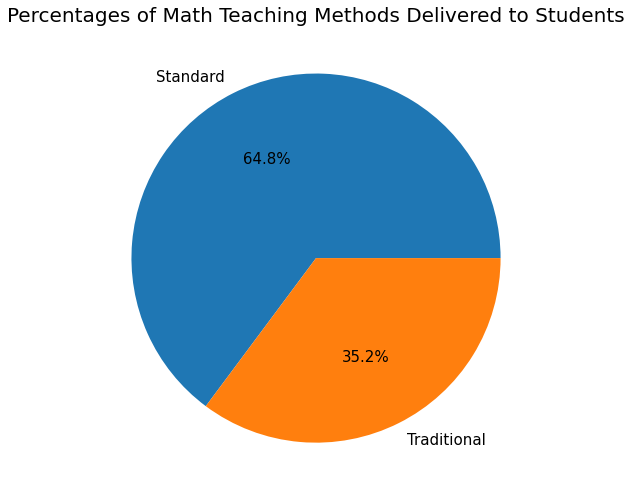

In [13]:
plt.figure(figsize = (7, 7))
plt.pie(sortedDf.Method.value_counts().values, labels = sortedDf.Method.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Percentages of Math Teaching Methods Delivered to Students', fontsize=20)
plt.tight_layout()
plt.show()

Note that only 35.2% of students are learning traditionally. Standard teaching is being delivered almost twice more since 2 teachers are adhering to the standard-based approach while only 1 teaccher is to the traditional approach.

<Figure size 1440x1440 with 0 Axes>

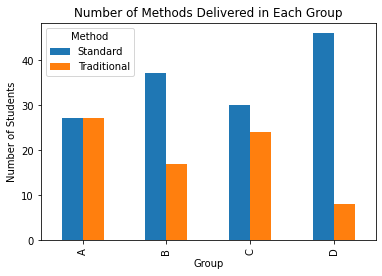

In [14]:
groupMethod = pd.pivot_table(sortedDf, index ="Group", columns="Method", aggfunc="count", values="Score")

plt.figure(figsize = (20, 20))
groupMethod.plot(kind ='bar')
plt.title("Number of Methods Delivered in Each Group")
plt.ylabel("Number of Students")
plt.show()

Interestingly enough, group A has the same number of students for both Standard and Traditional methods. This could signify there are some other factors contributing to their high scores. Group B has almost twice more students taking Standard-based style math classes. C also has more students from Standard classes; however, the discrepancy between the two methods is very close.

What we probably take a closer look at is group D. Even with the consideration that twice more students are taking Standard math classes, a noticeable number of failing students are from the Standard classes.

### Number of Students Learning from Different Teachers by Group

<Figure size 1440x1440 with 0 Axes>

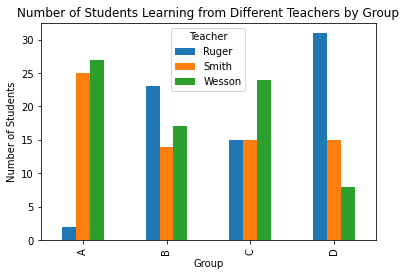

In [15]:
groupTeacher = pd.pivot_table(sortedDf, index ="Group", columns="Teacher", aggfunc="count", values="Score")

plt.figure(figsize = (20, 20))
groupTeacher.plot(kind ='bar')
plt.title("Number of Students Learning from Different Teachers by Group")
plt.ylabel("Number of Students")
plt.show()

Earlier in the previous section where we inspected the number of each method delivered to students, we observed teaching methods did not matter to the group A students. However, in this graph, we can see almost all students in group A who received standard-based style teaching were from Ms. Smith's class. It seems like students from Ms. Ruger's class are generally receiving lower grades. Her students account for most group D students.

The school was looking for a more efficient method to educate their students; however, they may have to focus more on evaluating their instructors' teaching capabilities.

### Number of Student Genders by Group

<Figure size 1440x1440 with 0 Axes>

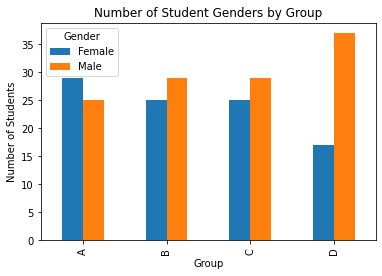

In [16]:
groupGender = pd.pivot_table(sortedDf, index ="Group", columns="Gender", aggfunc="count", values="Score")

plt.figure(figsize = (20, 20))
groupGender.plot(kind ='bar')
plt.title("Number of Student Genders by Group")
plt.ylabel("Number of Students")
plt.show()

There is not much difference in genders for groups A, B, and C; however, group D has significantly more male students.

### Number of Student Ethnicities by Group

<Figure size 1440x1440 with 0 Axes>

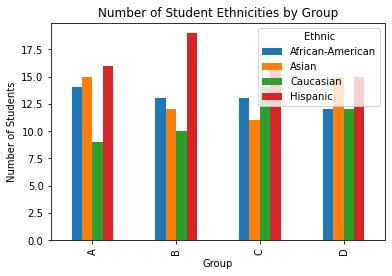

In [17]:
groupEth = pd.pivot_table(sortedDf, index ="Group", columns="Ethnic", aggfunc="count", values="Score")

plt.figure(figsize = (20, 20))
groupEth.plot(kind ='bar')
plt.title("Number of Student Ethnicities by Group")
plt.ylabel("Number of Students")
plt.show()

Nothing too significant is found in students' ethnicities.

### Number of Students Receiving "Freer Education" by Group
The school provides free lunch to eligible students based on their socioeconomic status.

<Figure size 1440x1440 with 0 Axes>

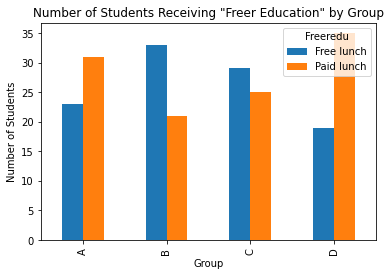

In [18]:
groupFreerEdu = pd.pivot_table(sortedDf, index ="Group", columns="Freeredu", aggfunc="count", values="Score")

plt.figure(figsize = (20, 20))
groupFreerEdu.plot(kind ='bar')
plt.title('Number of Students Receiving "Freer Education" by Group')
plt.ylabel("Number of Students")
plt.show()

Students who are paying for lunch seem to be either doing very well or very poorly academically. Both groups A and D have more paid lunch students.

## Data Treatment

### Removing Null Row
As seen in the EDA, there was a single row with everything empty. Although we should avoid removing any rows from the original dataset, we have deleted this row as it is hard to how this row can contribute to building a model.

### Dropping Irrelevant Columns
Following columns are dropped due to the lack of their correlations with the student scores.
- Student: this column is simply an incremental number to distinguish each student.
- wesson: The teacher column can also show which method is being delivered. Based on EDA, it is the teacher who affects more to students' performances rather than the teaching method; therefore, it is reaesonable to remove wesson over Teacher.

In [19]:
# drop Student and wesson columns
studentDf = df.drop(['Student', 'wesson'], axis=1)

studentDf

,Teacher,Gender,Ethnic,Freeredu,Score
0,Ruger,Female,Asian,Free lunch,76.0
1,Ruger,Female,Hispanic,Paid lunch,56.0
2,Ruger,Female,African-American,Free lunch,34.0
3,Ruger,Female,Asian,Paid lunch,59.0
4,Ruger,Male,Hispanic,Free lunch,73.0
...,...,...,...,...,...
211,Wesson,Male,African-American,Paid lunch,56.0
212,Wesson,Male,Hispanic,Free lunch,94.0
213,Wesson,Male,Hispanic,Paid lunch,91.0
214,Wesson,Female,African-American,Paid lunch,53.0


### Dummy Variables

We are working with dataset that all the features are cactegorical. They will be put into dummy variables before developing models.

In [20]:
cat_col_li = ['Teacher', 'Gender', 'Ethnic', 'Freeredu']

# to grab the added dummy columns later.
original_col_num = len(studentDf.columns.values)

# create dummy variables for all flags
temp_cat_df = studentDf[cat_col_li]
dummy_cat_df = pd.get_dummies(temp_cat_df, columns=cat_col_li)
studentDf = pd.concat(([studentDf, dummy_cat_df]), axis=1)

changed_col_num = len(studentDf.columns.values)
n_added = changed_col_num - original_col_num
# grab a list of added column names
dummy_flag_col_li = studentDf.columns.values[n_added * -1:]

studentDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 215
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Teacher                  216 non-null    category
 1   Gender                   216 non-null    category
 2   Ethnic                   216 non-null    category
 3   Freeredu                 216 non-null    category
 4   Score                    216 non-null    float64 
 5   Teacher_Ruger            216 non-null    uint8   
 6   Teacher_Smith            216 non-null    uint8   
 7   Teacher_Wesson           216 non-null    uint8   
 8   Gender_Female            216 non-null    uint8   
 9   Gender_Male              216 non-null    uint8   
 10  Ethnic_African-American  216 non-null    uint8   
 11  Ethnic_Asian             216 non-null    uint8   
 12  Ethnic_Caucasian         216 non-null    uint8   
 13  Ethnic_Hispanic          216 non-null    uint8   
 14  Freeredu_F

In [21]:
studentDf.head(5)

,Teacher,Gender,Ethnic,Freeredu,Score,Teacher_Ruger,Teacher_Smith,Teacher_Wesson,Gender_Female,Gender_Male,Ethnic_African-American,Ethnic_Asian,Ethnic_Caucasian,Ethnic_Hispanic,Freeredu_Free lunch,Freeredu_Paid lunch
0,Ruger,Female,Asian,Free lunch,76.0,1,0,0,1,0,0,1,0,0,1,0
1,Ruger,Female,Hispanic,Paid lunch,56.0,1,0,0,1,0,0,0,0,1,0,1
2,Ruger,Female,African-American,Free lunch,34.0,1,0,0,1,0,1,0,0,0,1,0
3,Ruger,Female,Asian,Paid lunch,59.0,1,0,0,1,0,0,1,0,0,0,1
4,Ruger,Male,Hispanic,Free lunch,73.0,1,0,0,0,1,0,0,0,1,1,0


Notice newly created columns that contain binary numbers to indicate the student's traits.

## Model Development and Tuning
Models will predict students' math grade group based on their genders, socioeconomic status, ethnicities and teachers. They will be used to predict the ideal class (teacher) a student should attend to get the highest score.

In [22]:
featureNLi = [
'Teacher_Ruger'
, 'Teacher_Smith'
, 'Teacher_Wesson'
, 'Gender_Female'
, 'Gender_Male'
, 'Ethnic_African-American'
, 'Ethnic_Asian'
, 'Ethnic_Caucasian'
, 'Ethnic_Hispanic'
, 'Freeredu_Free lunch'
, 'Freeredu_Paid lunch'
]

### Chi-Square Scores for the Features Selection

In [23]:
X = studentDf[featureNLi]
y = studentDf['Score']

In [24]:
test = SelectKBest(score_func=chi2, k="all")

# Use scaled data to fit KBest
chiScores = test.fit(X, y)  # Summarize scores
np.set_printoptions(precision=3)

# Create a sorted list of the top features.
dfFeatures = pd.DataFrame()
for i in range(0, len(chiScores.scores_)):
    headers = list(X.keys())
    featureObject = {"feature": headers[i], "chi-square score": chiScores.scores_[i]}
    dfFeatures = dfFeatures.append(featureObject, ignore_index=True)

dfFeatures = dfFeatures.sort_values(by=['chi-square score'])
print(dfFeatures.tail(40))

                    feature  chi-square score
4               Gender_Male         25.587857
10      Freeredu_Paid lunch         28.723724
9       Freeredu_Free lunch         30.933242
3             Gender_Female         31.984821
1             Teacher_Smith         38.925466
8           Ethnic_Hispanic         42.144156
5   Ethnic_African-American         42.811538
6              Ethnic_Asian         43.705121
2            Teacher_Wesson         46.457519
7          Ethnic_Caucasian         48.988571
0             Teacher_Ruger         62.500604


Generally with the Chi-square scores, we select features that have scores equal to or higher than 3.8. All predictor variables of our model seem to have good scores. 

### Linear Regression

In [25]:
X = studentDf[featureNLi]

# Adding an intercept
X = sm.add_constant(X)
y = studentDf['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lrModel = sm.OLS(y_train, X_train).fit()
predictions = lrModel.predict(X_test) # make the predictions by the model
print(lrModel.summary())
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, predictions)))

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     6.740
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           5.01e-07
Time:                        00:20:45   Log-Likelihood:                -707.21
No. Observations:                 172   AIC:                             1430.
Df Residuals:                     164   BIC:                             1456.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

As advised by the chi-square score, all features were used to build a basic linear regression model. Teacher_Ruger has a p-value as high as 0.441, which makes it statistically insignificant. Moreover, it is the only coefficient that is negatively correlated with the target variable. We are certain Ms.Ruger is negatively impacting studuents' performances.

Teacher_Ruger is removed from the feature list as well as "Freeredu_Free lunch" and "Freeredu_Paid lunch" as those two generated low Chi-Square scores compared to the others.

In [26]:
featureNLi = [
'Teacher_Smith'
, 'Teacher_Wesson'
, 'Gender_Female'
, 'Gender_Male'
, 'Ethnic_African-American'
, 'Ethnic_Asian'
, 'Ethnic_Caucasian'
, 'Ethnic_Hispanic'
]

In [27]:
X = studentDf[featureNLi]

# Adding an intercept
X = sm.add_constant(X)
y = studentDf['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     6.562
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           3.11e-06
Time:                        00:20:45   Log-Likelihood:                -704.66
No. Observations:                 172   AIC:                             1423.
Df Residuals:                     165   BIC:                             1445.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [28]:
lrRMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', lrRMSE)

Root Mean Squared Error: 14.614322158075678


The RMSE may be a bit higher; however, all feature variables are statistically significant now.

### Neural Network Model

#### Optimized Parameters
Below are the optimized parameters found after running multiple grid searches and calibrations.

| Parameter | Value |
| --- | --- |
| Batch size | 30 |
| epochs | 750 |
| Optimizer | Adamax |
| Learning Rate | 0.001 |
| Kernel Initializer | uniform |
| Number of neurons | 10 |
| Number of hidden layers | 0 |

#### Final Model

In [29]:
X = studentDf[featureNLi].values
y = studentDf['Score'].values

ROW_DIM = 0
COL_DIM = 1

x_arrayReshaped = X.reshape(X.shape[ROW_DIM], X.shape[COL_DIM])
y_arrayReshaped = y.reshape(y.shape[ROW_DIM],1)

In [30]:
# Split the data.
X_train, X_test, y_train, y_test = train_test_split(x_arrayReshaped,
         y_arrayReshaped, test_size=0.2)

n_features = X_train.shape[1]

In [31]:
def baseline_model():
   model = Sequential()
   model.add(Dense(10, input_dim=n_features, kernel_initializer='uniform',
             activation="softplus"))

   model.add(Dense(1, kernel_initializer='uniform'))

   opt = Adamax(lr=0.001)
   model.compile(loss='mean_squared_error', optimizer=opt)
   return model

In [32]:
# build model
model = baseline_model()
history = model.fit(X_train, y_train, epochs=750,
                    batch_size=30, verbose=1,
                    validation_data=(X_test, y_test))
predictions = model.predict(X_test)

mse = metrics.mean_squared_error(y_test, predictions)

2022-04-29 00:20:47.952333: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-04-29 00:20:48.119073: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/750
6/6 [==============================] - 1s 36ms/step - loss: 4427.4790 - val_loss: 4852.3926
Epoch 2/750
6/6 [==============================] - 0s 9ms/step - loss: 4421.3330 - val_loss: 4845.9849
Epoch 3/750
6/6 [==============================] - 0s 8ms/step - loss: 4415.1611 - val_loss: 4839.4155
Epoch 4/750
6/6 [==============================] - 0s 9ms/step - loss: 4408.8501 - val_loss: 4832.8911
Epoch 5/750
6/6 [==============================] - 0s 8ms/step - loss: 4402.5576 - val_loss: 4826.3335
Epoch 6/750
6/6 [==============================] - 0s 8ms/step - loss: 4396.3208 - val_loss: 4819.5879
Epoch 7/750
6/6 [==============================] - 0s 8ms/step - loss: 4389.7578 - val_loss: 4812.7734
Epoch 8/750
6/6 [==============================] - 0s 8ms/step - loss: 4383.3120 - val_loss: 4805.9531
Epoch 9/750
6/6 [==============================] - 0s 8ms/step - loss: 4376.6694 - val_loss: 4798.9565
Epoch 10/750
6/6 [==============================] - 0s 8ms/step - loss: 

In [33]:
annMSE = str(mse)
annRMSE = str(np.sqrt(mse))

print("Neural network MSE: " + annMSE)
print("Neural network RMSE: " + annRMSE)

Neural network MSE: 234.55903682379224
Neural network RMSE: 15.315320330433583


## Bagged Linear Regression
The linear regression model is bagged to reduce existing variance.

In [34]:
X = studentDf[featureNLi]
y = studentDf['Score']

# Split the data for linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
def evaluateModel(model, X_test, y_test, title):
    print("\n****** " + title)
    predictions = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('Root Mean Squared Error:', rmse)
    
    return rmse

In [36]:
# Build linear regression ensemble.
ensembleModel = BaggingRegressor(base_estimator=LinearRegression(),max_features=6,
                        max_samples =0.5,
                        n_estimators=750).fit(X_train, y_train)

baggedRMSE = evaluateModel(ensembleModel, X_test, y_test, "Bagging")


****** Bagging
Root Mean Squared Error: 16.52989741388127


In [37]:
# Build stand alone linear regression model.
model = LinearRegression()
model.fit(X_train, y_train)

evaluateModel(model, X_test, y_test, "Linear Regression")


****** Linear Regression
Root Mean Squared Error: 16.572930356354934


16.572930356354934

## Stacked Model
10 ANN models are stacked to improve model performances.

In [38]:
PATH_MODEL =  "./models/"
NUM_MODEL = 10
MODEL_NAME = "comp4948_a2_model_"

In [39]:
X = studentDf[featureNLi].values
y = studentDf['Score'].values

ROW_DIM = 0
COL_DIM = 1

x_arrayReshaped = X.reshape(X.shape[ROW_DIM], X.shape[COL_DIM])
y_arrayReshaped = y.reshape(y.shape[ROW_DIM],1)

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(x_arrayReshaped,
         y_arrayReshaped, test_size=0.2)

n_features = X_train.shape[1]

In [40]:
# fit model on dataset
def fit_model(trainX, trainy):
    model = Sequential()
    model.add(Dense(10, input_dim=n_features, kernel_initializer='uniform',
                    activation="softplus"))

    model.add(Dense(1, kernel_initializer='uniform'))

    opt = Adamax(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    # fit model
    history = model.fit(trainX, trainy, epochs=750, batch_size=30, verbose=1, validation_data=(X_test, y_test))

    return model, history

In [41]:
def generateModels(trainX, trainy):
    # create directory for models
    if (not path.exists(PATH_MODEL)):
        makedirs('./models')

    # fit and save models
    for i in range(NUM_MODEL):
        # fit model
        model, history = fit_model(trainX, trainy)

        # save model
        filename = PATH_MODEL + MODEL_NAME + str(i + 1) + '.h5'
        model.save(filename)
        print('>Saved %s' % filename)

In [42]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = PATH_MODEL + MODEL_NAME + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of models
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [43]:
# generate models
generateModels(X_train, y_train)

# load all models
models = load_all_models(NUM_MODEL)
print('Loaded %d models' % len(models))

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/750
6/6 [==============================] - 1s 32ms/step - loss: 4511.9492 - val_loss: 4508.5942
Epoch 2/750
6/6 [==============================] - 0s 9ms/step - loss: 4505.7944 - val_loss: 4502.4907
Epoch 3/750
6/6 [==============================] - 0s 9ms/step - loss: 4499.6313 - val_loss: 4496.3403
Epoch 4/750
6/6 [==============================] - 0s 10ms/step - loss: 4493.4497 - val_loss: 4490.0298
Epoch 5/750
6/6 [==============================] - 0s 9ms/step - loss: 4487.1909 - val_loss: 4483.7031
Epoch 6/750
6/6 [==============================] - 0s 9ms/step - loss: 4480.8516 - val_loss: 4477.3125
Epoch 7/750
6/6 [==============================] - 0s 8ms/step - loss: 4474.3984 - val_loss: 4470.8965
Epoch 8/750
6/6 [==============================] - 0s 9ms/step - loss: 4467.9292 - val_loss: 4464.3726
Epoch 9/750
6/6 [==============================] - 0s 9ms/step - loss: 4461.4014 - val_loss: 4457.7676
Epoch 10/750
6/6 [==============================] - 0s 9ms/step - loss:

In [44]:
# # evaluate standalone models on test dataset
for model in models:
    mse = model.evaluate(X_test, y_test, verbose=0)
    print('Model MSE: %.3f' % mse)
    print('Model RMSE: %.3f' % np.sqrt(mse))

Model MSE: 175.718
Model RMSE: 13.256
Model MSE: 175.981
Model RMSE: 13.266
Model MSE: 175.840
Model RMSE: 13.260
Model MSE: 176.396
Model RMSE: 13.281
Model MSE: 175.466
Model RMSE: 13.246
Model MSE: 175.825
Model RMSE: 13.260
Model MSE: 175.951
Model RMSE: 13.265
Model MSE: 175.151
Model RMSE: 13.234
Model MSE: 176.721
Model RMSE: 13.294
Model MSE: 176.054
Model RMSE: 13.269


In [45]:
# create stacked model input dataset as outputs from the ensemble
def getStackedData(models, inputX):
    stackXdf = None
    for model in models:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        singleModelPredDf = pd.DataFrame(np.row_stack(yhat))

        if stackXdf is None:
            stackXdf = singleModelPredDf
        else:
            numClasses = len(singleModelPredDf.keys())
            numStackXCols = len(stackXdf.keys())

            # Add new classification columns.
            for i in range(0, numClasses):
                stackXdf[numStackXCols + i] = singleModelPredDf[i]
    return stackXdf

In [46]:
# Make predictions with the stacked model
def stacked_prediction(models, model, inputX):
    # create dataset using ensemble
    stackedX = getStackedData(models, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [47]:
# fit a model based on the outputs from the ensemble models
def fit_stacked_model(models, inputX, inputy):
    # create dataset using ensemble
    stackedX = getStackedData(models, inputX)
    # fit standalone model
    model = LinearRegression()
    history = model.fit(stackedX, inputy)
    # showLoss(history, "Loss - Stacked")
    return model

In [48]:
# fit stacked model using the ensemble
model = fit_stacked_model(models, X_test, y_test)

In [49]:
# evaluate model on test set
yhat = stacked_prediction(models, model, X_test)
stackedRmse = mean_squared_error(y_test, yhat, squared=False)
print('\n*****Stacked Test RMSE: %.3f' % stackedRmse)


*****Stacked Test RMSE: 11.637


## Model Evaluation
RMSE of each model will be compared and evaluated here to determine the best model.

In [50]:
modelEvalDict = {
    "Model Type" : ["Linear Regression", "Neural Network", "Bagged Linear Regression", "Stacked Model"]
    , "RMSE" : [lrRMSE, annRMSE, baggedRMSE, stackedRmse]
}

modelEvalDf = pd.DataFrame(modelEvalDict)

modelEvalDf

,Model Type,RMSE
0,Linear Regression,14.614322
1,Neural Network,15.315320330433583
2,Bagged Linear Regression,16.529897
3,Stacked Model,11.637384


The stacked model outperformed all the other models with the lowest RMSE. Please note the numbers may be a bit different from what are recorded on the notebook as they are results of one sample trial run.

# Conclusion and Suggestions
Using the best model built above, we will look into what method and instructor students need to work with to perform better.

First, a dummy data will be created to be fed to the model. Each row signifies every possible combinations of student traits (ethnicities + genders).

In [51]:
PATH_MODEL =  "D:\\Roelle\\BCIT\\Term 4\\COMP 4948 Maching Learning\\Assignment\\A2\\code\\model\\models\\"
MODEL_NAME = "comp4948_a2_model_"

In [52]:
teacherLi = ["Teacher_Smith", "Teacher_Wesson"]
genderLi = ["Gender_Female", "Gender_Male"]
ethnicityLi = ["Ethnic_African-American", "Ethnic_Asian", "Ethnic_Caucasian", "Ethnic_Hispanic"]

In [53]:
X = studentDf[featureNLi].values
y = studentDf['Score'].values

ROW_DIM = 0
COL_DIM = 1

x_arrayReshaped = X.reshape(X.shape[ROW_DIM], X.shape[COL_DIM])
y_arrayReshaped = y.reshape(y.shape[ROW_DIM],1)

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(x_arrayReshaped,
         y_arrayReshaped, test_size=0.2)

In [54]:
def buildX(teacher, gender, ethnicity):
    """
    Create a blank template for student data and add 1 to passed values.
    :param teacher: str
    :param gender: str
    :param ethnicity: str
    :return: a new dataframe of a single row that represents one student trait.
    """
    blankDf = pd.DataFrame({
        "Teacher_Smith": [0]
        , "Teacher_Wesson": [0]
        , "Gender_Female" : [0]
        , "Gender_Male" : [0]
        , "Ethnic_African-American" : [0]
        , "Ethnic_Asian" : [0]
        , "Ethnic_Caucasian" : [0]
        , "Ethnic_Hispanic" : [0]
    })

    blankDf[teacher] = 1
    blankDf[gender] = 1
    blankDf[ethnicity] = 1

    return blankDf

In [55]:
# create all possibilities of student traits coordinating genders, ethnicities and teachers
forEvalDf = pd.DataFrame()

for teacher in teacherLi:
    for gender in genderLi:
        for ethnic in ethnicityLi:
            newRow = (buildX(teacher, gender, ethnic))
            forEvalDf = pd.concat([forEvalDf, newRow])
            
forEvalDf.head(5)

,Teacher_Smith,Teacher_Wesson,Gender_Female,Gender_Male,Ethnic_African-American,Ethnic_Asian,Ethnic_Caucasian,Ethnic_Hispanic
0,1,0,1,0,1,0,0,0
0,1,0,1,0,0,1,0,0
0,1,0,1,0,0,0,1,0
0,1,0,1,0,0,0,0,1
0,1,0,0,1,1,0,0,0


Each row indicates a unique combination of student's traits. This dataframe will be now fed to the stacked model.

In [56]:
models = load_all_models(NUM_MODEL)
model = fit_stacked_model(models, X_test, y_test)
yhat = stacked_prediction(models, model, forEvalDf)

OSError: SavedModel file does not exist at: D:\Roelle\BCIT\Term 4\COMP 4948 Maching Learning\Assignment\A2\code\model\models\comp4948_a2_model_1.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
yhat = yhat.tolist()
yhatLi = []

# convert to list
for y in yhat:
    yhatLi.append(y[0])

# add prediction array as a Score column
forEvalDf['Score'] = np.array(yhatLi)

Using the prediction data, a new dataframe will be created to easily compare math scores of each student trait.

In [ ]:
def suggestTeacher(df: pd.DataFrame):
    """
    Create a new dataframe that compares scores for each student trait.
    :param df: pd.DataFrame
    :return: new dataframe
    """
    resDf = pd.DataFrame()
    for i in range(df.shape[0]):
        tmpSeries = df.iloc[i]

        if tmpSeries["Teacher_Smith"] == 1:
            teacher = "Smith"
        else:
            teacher = "Wesson"

        if tmpSeries["Gender_Female"] == 1:
            gender = "Female"
        else:
            gender = "male"

        if tmpSeries["Ethnic_African-American"] == 1:
            ethnic = "African-American"
        elif tmpSeries["Ethnic_Asian"] == 1:
            ethnic = "Asian"
        elif tmpSeries["Ethnic_Caucasian"] == 1:
            ethnic = "Caucasian"
        else:
            ethnic = "Hispanic"

        tmpRow = pd.DataFrame({
            "Teacher" : [teacher]
            , "Gender" : [gender]
            , "Ethnicity" : [ethnic]
            , "Score" : [tmpSeries["Score"]]
        })

        resDf = pd.concat([resDf, tmpRow], ignore_index=True)
        resDf.sort_values(by=["Gender", "Ethnicity", "Score"], ascending=False, inplace=True, ignore_index=True)

    return resDf

In [ ]:
suggestionDf = suggestTeacher(forEvalDf)
suggestionDf

We can easily compare predicted scores and find out which teacher is more likely to help students get better scores on Math. Again, Ms. Ruger was removed from the consideration as it appeared her class negatively impacts students' performances.

In [ ]:
groupTeacher = pd.pivot_table(suggestionDf, index=["Gender", "Ethnicity"], columns=["Teacher"], aggfunc="sum", values="Score")

plt.figure(figsize = (50, 50))
groupTeacher.plot(kind ='bar')
plt.title("Score Comparisons for Different Teachers By Student Traits")
plt.ylabel("Scores")
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
          ncol=3, fancybox=True, shadow=True)
plt.show()


It is predicted that all categories of students would perform better when they are taught by Ms. Smith. Both Ms. Smith and Ms. Wesson appear to be very capable teachers, but this may indicate the standard-based teaching method would generally improve students' grades.